Enter the number of stocks in the portfolio:  6
Enter ticker symbol for stock 1:  CVS
Enter ticker symbol for stock 2:  BLK
Enter ticker symbol for stock 3:  NVDA
Enter ticker symbol for stock 4:  GOOG
Enter ticker symbol for stock 5:  TSLA
Enter ticker symbol for stock 6:  MSFT
Enter start date (YYYY-MM-DD):  2010-01-01
Enter end date (YYYY-MM-DD):  2024-12-16


[*********************100%***********************]  6 of 6 completed


Ticker              BLK        CVS        GOOG        MSFT        NVDA  \
Date                                                                     
2010-01-04   161.579636  23.475384   15.554351   23.300680    0.423923   
2010-01-05   162.277145  23.382847   15.485855   23.308208    0.430113   
2010-01-06   158.931503  23.176432   15.095475   23.165173    0.432864   
2010-01-07   160.678833  24.030588   14.744060   22.924261    0.424381   
2010-01-08   161.809860  24.201433   14.940615   23.082352    0.425298   
...                 ...        ...         ...         ...         ...   
2024-12-09  1046.380005  56.070000  177.100006  446.019989  138.809998   
2024-12-10  1057.069946  55.150002  186.529999  443.329987  135.070007   
2024-12-11  1065.260010  51.759998  196.710007  448.989990  139.309998   
2024-12-12  1058.819946  49.580002  193.630005  449.559998  137.339996   
2024-12-13  1056.540039  49.369999  191.380005  447.269989  134.250000   

Ticker            TSLA  
Date        

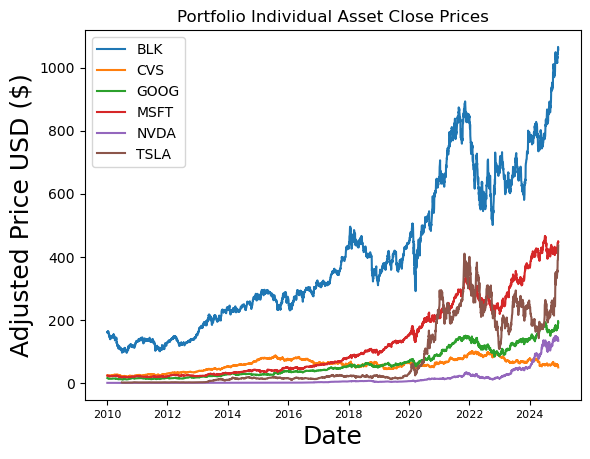

Ticker
BLK     0.200750
CVS     0.089350
GOOG    0.233320
MSFT    0.256474
NVDA    0.540523
TSLA    0.552041
dtype: float64
Ticker       BLK       CVS      GOOG      MSFT      NVDA      TSLA
Ticker                                                            
BLK     0.074550  0.028162  0.037892  0.039110  0.057039  0.050466
CVS     0.028162  0.061997  0.018468  0.020080  0.022700  0.023069
GOOG    0.037892  0.018468  0.074722  0.044655  0.061339  0.051117
MSFT    0.039110  0.020080  0.044655  0.065674  0.065381  0.050741
NVDA    0.057039  0.022700  0.061339  0.065381  0.206644  0.093571
TSLA    0.050466  0.023069  0.051117  0.050741  0.093571  0.328522
[0.27303838 0.24899188 0.27335255 0.25627009 0.45458094 0.57316848]
0.10254290001207625
0.32022320342547983
109.43449261976617
Optimal Weights for Maximum Sharpe Ratio:
CVS: 0.00%
BLK: 0.00%
NVDA: 7.81%
GOOG: 29.88%
TSLA: 39.81%
MSFT: 22.50%


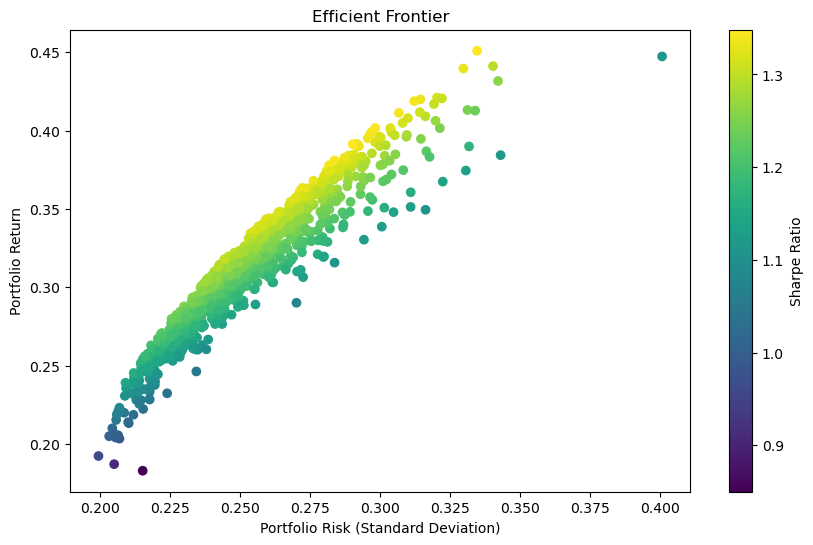

Enter the initial portfolio value:  10000
Enter the number of Monte Carlo simulations:  100
Enter the number of days to simulate:  100


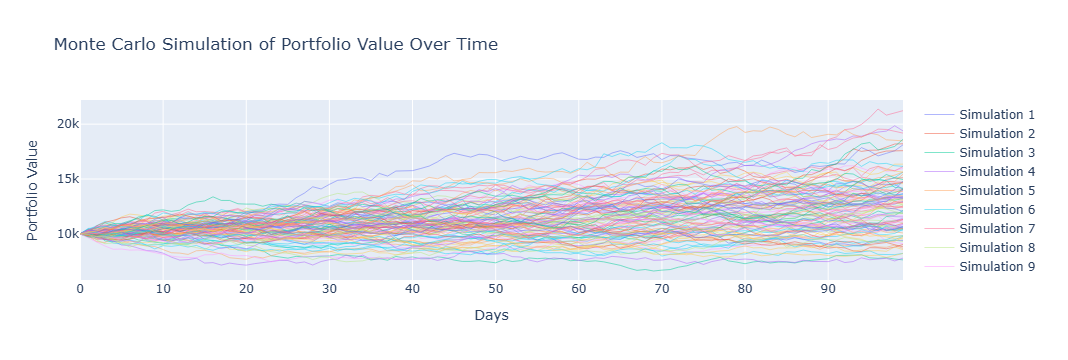

Ending Mean Value: $12720.52
Ending Standard Deviation: $2760.62
0th Percentile: $7631.82
10th Percentile: $9393.23
20th Percentile: $10487.25
30th Percentile: $10943.20
40th Percentile: $11875.61
50th Percentile: $12736.84
60th Percentile: $13260.94
70th Percentile: $13730.22
80th Percentile: $14733.83
90th Percentile: $16132.46
100th Percentile: $21229.23


In [6]:
# Import the neccessary libraries neccessary for our analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
import plotly.graph_objects as go

# Create a function that will store the financial data of specific stocks for a span of time
def get_stock_data(tickers, start_date, end_date):
    """Fetch historical data for a list of stocks."""
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Create a function that will compute the expected annual return of each stock by scaling the average percent change in close prices to the 252 open
# trading days in a year in the US stock market, along with the covariance matrix and volatilities of the selected stocks from the data in the
# selected time frame of analysis
def calculate_annualized_metrics(returns):
    """Calculate annualized return, variance, and volatility."""
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    volatilities = np.sqrt(np.diag(cov_matrix))
    return mean_returns, cov_matrix, volatilities

# Create a function that will compute the expected return and expected risk of the portfolio 
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and risk."""
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Create a function that modifies equal weights at the start to the weight of each stock that would lead to the maximum Sharpe Ratio using the
# Sequential Least Squares Programming method where weights must sum to 1
def optimize_portfolio(mean_returns, cov_matrix):
    """Find optimal portfolio weights for maximum Sharpe Ratio."""
    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1.0 / num_assets]

    def neg_sharpe_ratio(weights):
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        return -portfolio_return / portfolio_risk

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    result = minimize(neg_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Create a function that will plot the efficient frontier of our portfolio so we can evaluate risk vs return payoffs, and observe which combinations
# generate better or worse Sharpe Ratios. Sharpe Ratios indicate the level or return associated with a risk where 1 is "normal", the greater the
# Sharpe Ratio the more rewarding the investment is for the risk associated with it
def plot_efficient_frontier(mean_returns, cov_matrix):
    """Generate the efficient frontier."""
    results = []
    num_assets = len(mean_returns)
    for _ in range(1000):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results.append((portfolio_return, portfolio_risk))
    results = np.array(results)
    plt.figure(figsize=(10, 6))
    plt.scatter(results[:, 1], results[:, 0], c=results[:, 0] / results[:, 1], cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier')
    plt.show()

# Create functions that will plot Monte Carlo simulations of the optimal portfolio based on optimal weights based on the initial portfolio amount
# input by the user, the number of simulations, and the number of days simulating over - while returning the mean, standard deviation, and
# every 10th percentile price value for the simulated data
def monte_carlo_portfolio_simulation(data, optimal_weights, initial_value, num_simulations, num_days):
    """Run Monte Carlo simulations for portfolio performance over time."""
    daily_returns = data.pct_change().dropna()
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    
    simulations = np.zeros((num_simulations, num_days))
    simulations[:, 0] = initial_value
    
    for sim in range(num_simulations):
        for day in range(1, num_days):
            daily_return = np.random.multivariate_normal(mean_returns, cov_matrix)
            portfolio_daily_return = np.sum(optimal_weights * daily_return)
            simulations[sim, day] = simulations[sim, day-1] * (1 + portfolio_daily_return)
    
    return simulations

def plot_monte_carlo_simulations(simulations, num_days):
    """Plot Monte Carlo simulations with interactive hover."""
    fig = go.Figure()
    
    for i in range(simulations.shape[0]):
        fig.add_trace(go.Scatter(
            y=simulations[i],
            x=list(range(num_days)),
            mode='lines',
            name=f'Simulation {i+1}',
            hoverinfo='x+y',
            line=dict(width=1),
            opacity=0.5
        ))
    
    fig.update_layout(
        title='Monte Carlo Simulation of Portfolio Value Over Time',
        xaxis_title='Days',
        yaxis_title='Portfolio Value',
        hovermode='closest'
    )
    
    fig.show()

def main():
    # User inputs
    num_stocks = int(input("Enter the number of stocks in the portfolio: "))
    tickers = [input(f"Enter ticker symbol for stock {i+1}: ") for i in range(num_stocks)]
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")

    # Fetch stock data
    data = get_stock_data(tickers, start_date, end_date)
    daily_returns = data.pct_change().dropna()
    print(data)
    print(daily_returns)

    # Visualize stock prices over time window
    title = 'Portfolio Individual Asset Close Prices'
    my_stocks = data
    for c in my_stocks.columns.values:
        plt.plot(my_stocks[c], label = c)
    plt.title(title)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Adjusted Price USD ($)', fontsize = 18)
    plt.xticks(fontsize = 8)
    plt.legend(my_stocks.columns.values, loc = 'upper left')
    plt.show()
    plt.ymin = 0

    # Calculate portfolio metrics
    mean_returns, cov_matrix, volatilities = calculate_annualized_metrics(daily_returns)
    print(mean_returns)
    print(cov_matrix)
    print(volatilities)
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix)
    
    portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    print(portfolio_variance)
    print(portfolio_volatility)
    expected_portfolio_return = np.sum(mean_returns*optimal_weights*252)
    print(expected_portfolio_return)

    # Display results
    print("Optimal Weights for Maximum Sharpe Ratio:")
    for ticker, weight in zip(tickers, optimal_weights):
        print(f"{ticker}: {weight:.2%}")
    
    # Efficient Frontier
    plot_efficient_frontier(mean_returns, cov_matrix)

    initial_value = float(input("Enter the initial portfolio value: "))
    num_simulations = int(input("Enter the number of Monte Carlo simulations: "))
    num_days = int(input("Enter the number of days to simulate: "))
    
    simulations = monte_carlo_portfolio_simulation(data, optimal_weights, initial_value, num_simulations, num_days)
    plot_monte_carlo_simulations(simulations, num_days)
    ending_values = simulations[:, -1]
    ending_mean = np.mean(ending_values)
    ending_std = np.std(ending_values)

    print(f"Ending Mean Value: ${ending_mean:.2f}")
    print(f"Ending Standard Deviation: ${ending_std:.2f}")

    # Calculate and display prices at every 10th percentile
    percentiles = np.percentile(ending_values, range(0, 101, 10))
    for i, percentile in enumerate(percentiles):
        print(f"{i*10}th Percentile: ${percentile:.2f}")

if __name__ == "__main__":
    main()